![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRjFm003pSAOtHmnUm7e--Xquwo90Hp5-U_3wSZrkChGz4tQYWZ)
# Introduction to Machine Learning
## Innopolis University 
### Week 12: Autoencoders

Plan:

1) KL Divergence

2) In this lab you will implement autoencoder in pytorch.


## KL Divergence

### Why:

Calculate divergence between two distributions

### Formula:

$$D_{KL}(P||Q) = \sum_{x\in X} p(x) \log(\frac{p(x)}{q(x)})$$

### Example:

Last semester on Probability and Statistics course students got next grades:

17 students got A grade, \
62 students got B grade, \
50 students got C grade, \
44 students got D grade, \

Ekaterina told her father that there are almost equal part of students got each grade.
And Oydinoy told her mother that nobody got an A grade, and all other grades are equally distributed. Calculate KL divergences between the true distribution and that messages.

## Autoencoder

Now we will implement our own autoencoder. Almost from scratch.

At first make sure that you can you use GPU.

In [0]:
import torch
# Device configuration
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Run on", device_name)
device = torch.device(device_name)

Run on cuda


If it writes "Run on cuda" - congratulations, you will get a huge computational advantage. 

Otherwise:  
Edit > Notebook settings or Runtime > Change runtime type and select GPU as Hardware accelerator.

## Network in pytorch

Now we will write everything in our own. 

You might copy and paste some lines from the [previous lab](https://colab.research.google.com/drive/1yEtyG6sK208y3xTNeEEN8eBYlUpuWFXe#scrollTo=lLYOztuGtZQr&forceEdit=true&sandboxMode=true).

We also recommend you to read this [tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) (refer during the lab if you need and follow it in your self studying time).

In [0]:
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

# Set Hyperparameters

epoch = 10
batch_size =100
learning_rate = 0.001

### Data

Create datasets.MNIST for the train data. There is only one transformation to be done - converting to the tensor. You can use code from [previous lab](https://colab.research.google.com/drive/1yEtyG6sK208y3xTNeEEN8eBYlUpuWFXe#scrollTo=lLYOztuGtZQr&forceEdit=true&sandboxMode=true) as an example.

In [0]:
### YOUR CODE HERE ###
mnist_train = datasets.MNIST("./", 
                         train=True, 
                         transform=transforms.ToTensor(), 
                         download=True)


Now make a dataloader for it. Batch size is defined above.

In [0]:
### YOUR CODE HERE ###
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True)

Let's check.

(1, 28, 28)


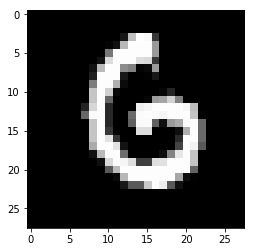

In [0]:
batch,labels = next(iter(train_loader))
image = batch[0]
np_image = image.data.numpy()
print(np_image.shape)
plt.imshow(np_image[0],cmap='gray')
plt.show()

### Models

For simplicity, first part of both encoder and decoder are implemented for you.

In the second part of encoder:


1.   Make a convolutional layer with 128 output channels with 3x3 kernels with the same size output. The number of input channels could be found as the previous layer outcome. You need to use padding.
2.   ReLU activation.
3.   Batch normalization.
4.   Max pooling with 2x2 size.
5.   Another convolutional layer with 3x3 kernels and 256 output channels. Again the same size.
6.   ReLU activation. 



In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,16,3,padding=1),   # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16,32,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 14 x 14
        )
        ### YOUR CODE HERE ###
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 64 x 7 x 7
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder().cuda()

Calculate the number of paramethers. Check [previous lab](https://colab.research.google.com/drive/1yEtyG6sK208y3xTNeEEN8eBYlUpuWFXe#scrollTo=lLYOztuGtZQr&forceEdit=true&sandboxMode=true) to see how to do it.

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  
print(count_parameters(encoder))

392800


You should get 392800.

Now implement the second part of decoder:



1.   Deconvolution, returning 16 channels, with 3x3 kernels same size.
2.   ReLU nonlinearity.
3.   Batch normalization.
4.   Deconvolution with one output chanel, 3x3 kernels, stride = 2, padding = 1, output padding = 1.
5.   ReLU nonlinearity.



In [0]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        ### YOUR CODE HERE ###
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda()

Now calculate the number of paramethers of the decoder:

In [0]:
### YOUR CODE HERE ###
print(count_parameters(decoder))

378625


It should be 378625.

Now show the input image and output from untrained autoencoder.

Make a batch from a train loader. Put it to the GPU using batch = Variable(batch).cuda()

In [0]:
### YOUR CODE HERE ###
batch,labels = next(iter(train_loader))
batch = Variable(batch).cuda()

print(batch.size())

torch.Size([100, 1, 28, 28])


Transform it using encoder and decoder sequentially.

In [0]:
### YOUR CODE HERE ###
output = encoder(batch)
output = decoder(output)

print(output.size())

torch.Size([100, 1, 28, 28])


To visualize results convert first image from the batch back to CPU. Do it for both input and output images. Use .cpu() method.

In [0]:
### YOUR CODE HERE ###
input_img = batch[0].cpu() nn.MSELoss() nn.MSELoss()
output_img = output[0].cpu()
print(input_img.size())
print(output_img.size()) nn.MSELoss() nn.MSELoss()

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


Convert them to numpy arrays and visualize results. Use .data.numpy() to convert.

Input image


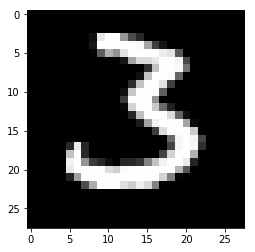

Output image


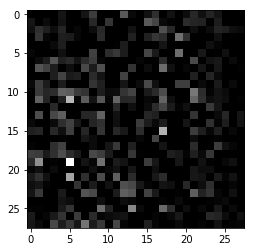

In [0]:
### YOUR CODE HERE ###
inp = input_img.data.numpy()
out = output_img.data.numpy()

print("Input image")
plt.imshow(inp[0],cmap='gray')
plt.show()

print("Output image")
plt.imshow(out[0],cmap="gray")
plt.show()

Take parameters from encoder and decoder. To concatenate them, simply convert to the list.

In [0]:
### YOUR CODE HERE ###
parameters = list(encoder.parameters())+ list(decoder.parameters())
print(type(parameters))
print(len(parameters))

<class 'list'>
32


You should get list of 32 elements.

Use MSE loss function. Use nn.MSELoss(), you don't need any paramethers.

In [0]:
### YOUR CODE HERE ###
loss_func = nn.MSELoss()

And Adam optimizer torch.optim.Adam. Arguments are your list parameters and lr=learning_rate, defined above.

In [0]:
### YOUR CODE HERE ###
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

### Training

Now let's train our model. All steps can be found in the [previous lab](https://colab.research.google.com/drive/1yEtyG6sK208y3xTNeEEN8eBYlUpuWFXe#scrollTo=lLYOztuGtZQr&forceEdit=true&sandboxMode=true).


For each batch in the training phase:

1.   Send the batch to the GPU: image = Variable(image).cuda()
2.   Set the gradients to zero.
3.   Calculate the output from the autoencoder.
4.   Calculate the loss function.
5.   Find partial derivatives using loss.backward().
6.   Update the paramethers with optimizer.step().




In [0]:
for i in range(epoch):
    print(i)
    encoder.train()
    decoder.train()
    for image,label in train_loader:
        ### YOUR CODE HERE ###
        image = Variable(image).cuda()
        optimizer.zero_grad()
        output = encoder(image)
        output = decoder(output)
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()

0
1
2
3
4
5
6
7
8
9


Make a visualization of input and output images again.

Input image


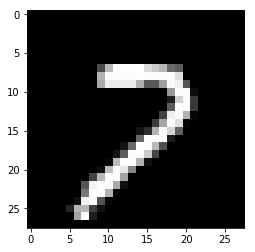

Output image


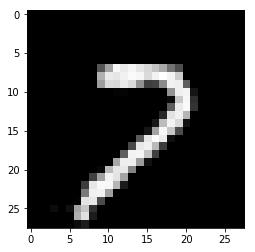

In [0]:
### YOUR CODE HERE ###
batch,labels = next(iter(train_loader))
batch = Variable(batch).cuda()

output = encoder(batch)
output = decoder(output)

input_img = batch[0].cpu()
output_img = output[0].cpu()

inp = input_img.data.numpy()
out = output_img.data.numpy()

print("Input image")
plt.imshow(inp[0],cmap='gray')
plt.show()

print("Output image")
plt.imshow(out[0],cmap="gray")
plt.show()

## Conclusion

Congratulations, if it works!

Why did we split encoder and decoder to 2 different models?

How to make a denoising autoencoder?

opt: change the code to make this autoencoder works as denoising autoencoder.

# References

https://github.com/GunhoChoi/Kind-PyTorch-Tutorial/blob/master/06_Autoencoder_Model_Save/Autoencoder_Model_Save.ipynb